In [ ]:
!pip install tensorflow_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from shutil import copyfile

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

In [ ]:
# Assign training and validation set directories
base_dir = '/content/gdrive/MyDrive/CAPSTONE II/'
train_dir = os.path.join(base_dir, 'train')
testing_dir = os.path.join(base_dir, 'test')

# Directory with training cat pictures
train_BigEyebag_dir = os.path.join(train_dir, 'BigEyebag')
train_NoEyebag_dir = os.path.join(train_dir, 'NoEyebag')
train_NormalEyebag_dir = os.path.join(train_dir, 'NormalEyebag')

# Directory with training dog pictures
testing_BigEyebag_dir = os.path.join(testing_dir, 'BigEyebag')
testing_NoEyebag_dir = os.path.join(testing_dir, 'NoEyebag')
testing_NormalEyebag_dir = os.path.join(testing_dir, 'NormalEyebag')

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 64
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  train_datagen = ImageDataGenerator(rescale=1/255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')


  train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

  validation_datagen = ImageDataGenerator(rescale=1/255)


  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE)
  return train_generator, validation_generator

# Test your generators
train_generator, validation_generator = train_val_generators(train_dir, testing_dir)

Found 822 images belonging to 3 classes.
Found 198 images belonging to 3 classes.


In [ ]:
image_batch, label_batch = next(validation_generator)
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 3))

In [ ]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('eyebag_labels.txt', 'w') as f:
  f.write(labels)

{'BigEyebag': 0, 'NoEyebag': 1, 'NormalEyebag': 2}


In [ ]:
!cat eyebag_labels.txt

BigEyebag
NoEyebag
NormalEyebag

In [ ]:
IMG_SHAPE = (224, 224, 3)

# Create the base model from the pre-trained MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')
base_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(units=3, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 5, 32)          368672    
                                                                 
 conv2d_6 (Conv2D)           (None, 3, 3, 64)          18496     
                                                                 
 dropout_3 (Dropout)         (None, 3, 3, 64)          0         
                                                                 
 global_average_pooling2d_3   (None, 64)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 3)                

In [ ]:
history = model.fit(train_generator,
                    
                    epochs=100,
                    validation_data=validation_generator)
                    

Epoch 1/50
13/13 [==============================] - 37s 3s/step - loss: 0.5897 - accuracy: 0.7238 - val_loss: 1.3541 - val_accuracy: 0.5303
Epoch 2/50
13/13 [==============================] - 37s 3s/step - loss: 0.6221 - accuracy: 0.7178 - val_loss: 1.7415 - val_accuracy: 0.5152
Epoch 3/50
13/13 [==============================] - 37s 3s/step - loss: 0.6113 - accuracy: 0.7336 - val_loss: 1.3042 - val_accuracy: 0.5455
Epoch 4/50
13/13 [==============================] - 38s 3s/step - loss: 0.6286 - accuracy: 0.7141 - val_loss: 1.2964 - val_accuracy: 0.4646
Epoch 5/50
13/13 [==============================] - 36s 3s/step - loss: 0.6329 - accuracy: 0.6995 - val_loss: 1.2408 - val_accuracy: 0.5051
Epoch 6/50
13/13 [==============================] - 37s 3s/step - loss: 0.6330 - accuracy: 0.6983 - val_loss: 1.2656 - val_accuracy: 0.5354
Epoch 7/50
13/13 [==============================] - 37s 3s/step - loss: 0.6185 - accuracy: 0.7080 - val_loss: 1.5101 - val_accuracy: 0.5101
Epoch 8/50
13/13 [==

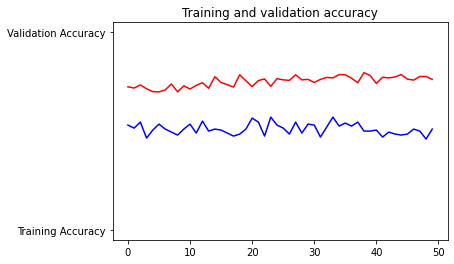

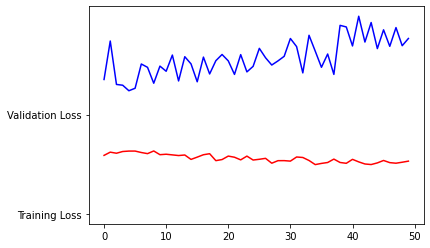

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [ ]:
base_model.trainable = True
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 5, 32)          368672    
                                                                 
 conv2d_6 (Conv2D)           (None, 3, 3, 64)          18496     
                                                                 
 dropout_3 (Dropout)         (None, 3, 3, 64)          0         
                                                                 
 global_average_pooling2d_3   (None, 64)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 3)                

In [ ]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 58


In [ ]:
history_fine = model.fit(train_generator,
                         steps_per_epoch=len(train_generator), 
                         epochs=10,
                         validation_data=validation_generator,
                         validation_steps=len(validation_generator))

Epoch 1/10
13/13 [==============================] - 64s 5s/step - loss: 1.6067 - accuracy: 0.5000 - val_loss: 1.7966 - val_accuracy: 0.5101
Epoch 2/10
13/13 [==============================] - 58s 4s/step - loss: 1.2710 - accuracy: 0.5450 - val_loss: 1.7757 - val_accuracy: 0.5152
Epoch 3/10
13/13 [==============================] - 58s 4s/step - loss: 1.1896 - accuracy: 0.5316 - val_loss: 1.7541 - val_accuracy: 0.5101
Epoch 4/10
13/13 [==============================] - 60s 5s/step - loss: 1.1177 - accuracy: 0.5523 - val_loss: 1.7425 - val_accuracy: 0.5202
Epoch 5/10
13/13 [==============================] - 59s 4s/step - loss: 1.0773 - accuracy: 0.5645 - val_loss: 1.7660 - val_accuracy: 0.5202
Epoch 6/10
13/13 [==============================] - 59s 4s/step - loss: 1.0549 - accuracy: 0.5572 - val_loss: 1.7473 - val_accuracy: 0.5152
Epoch 7/10
13/13 [==============================] - 59s 4s/step - loss: 0.9822 - accuracy: 0.5584 - val_loss: 1.7276 - val_accuracy: 0.5303
Epoch 8/10
13/13 [==

In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save("/content/gdrive/MyDrive/CAPSTONE II/eyebag_model_v1.h5")